## Neural Image Caption Generator using Tensorflow & Keras by implementing Bahdanau Attention (soft attention) and an Encoder-Decoder model

## Subsequent Implementation of Beam Search for effective Inference and model evaluation using BLEU metric

### For this notebook, please ensure you have tensorflow library installed (my version==2.4.0)

Note: Some knowledge on RNN-LSTM Models and Object Oriented Programming employed in Deep Learning Models is assumed

In [1]:
## Importing some relevant libraries

import os
import pandas as pd
import numpy as np

import glob
import pickle
import cv2

import matplotlib.pyplot as plt
from skimage.transform import resize

import unicodedata
import re

from tqdm import tqdm
import time

# Importing tensorflow packages
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Model, Input, Sequential

from tensorflow.keras.layers import Embedding, LSTM, Dense, Layer, \
                                    Activation, Softmax, Concatenate, TimeDistributed, Dropout

from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Section 1 - Data Processing

The dataset has been taken from - https://www.kaggle.com/adityajn105/flickr8k

After downloading, the images are places in 'Images' directory while 'captions.txt' is in root directory 

**Get the directory for all the image files in 'Images' directory**

In [2]:
images_paths = glob.glob("./Images/*")
images_paths

['./Images\\1000268201_693b08cb0e.jpg',
 './Images\\1001773457_577c3a7d70.jpg',
 './Images\\1002674143_1b742ab4b8.jpg',
 './Images\\1003163366_44323f5815.jpg',
 './Images\\1007129816_e794419615.jpg',
 './Images\\1007320043_627395c3d8.jpg',
 './Images\\1009434119_febe49276a.jpg',
 './Images\\1012212859_01547e3f17.jpg',
 './Images\\1015118661_980735411b.jpg',
 './Images\\1015584366_dfcec3c85a.jpg',
 './Images\\101654506_8eb26cfb60.jpg',
 './Images\\101669240_b2d3e7f17b.jpg',
 './Images\\1016887272_03199f49c4.jpg',
 './Images\\1019077836_6fc9b15408.jpg',
 './Images\\1019604187_d087bf9a5f.jpg',
 './Images\\1020651753_06077ec457.jpg',
 './Images\\1022454332_6af2c1449a.jpg',
 './Images\\1022454428_b6b660a67b.jpg',
 './Images\\1022975728_75515238d8.jpg',
 './Images\\102351840_323e3de834.jpg',
 './Images\\1024138940_f1fefbdce1.jpg',
 './Images\\102455176_5f8ead62d5.jpg',
 './Images\\1026685415_0431cbf574.jpg',
 './Images\\1028205764_7e8df9a2ea.jpg',
 './Images\\1030985833_b0902ea560.jpg',
 './

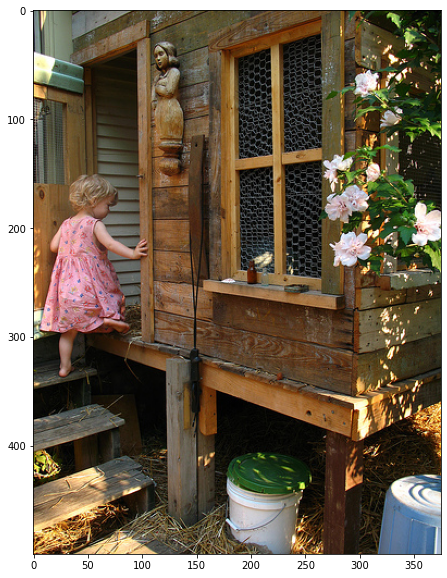

In [3]:
# Displaying an image

plt.figure(figsize=(15,10))
plt.imshow(plt.imread(images_paths[0]))
plt.show()

In [4]:
def resizing(img_path, img_shape=(250, 250)):
    
    """
    Function to resize images to the shape provided as an argument
    """

    img = plt.imread(img_path)

    # Resize and normalize using => from skimage.transform import resize
    padded_img = resize(img, (*img_shape, 3), mode='reflect') 
    
    
    return padded_img

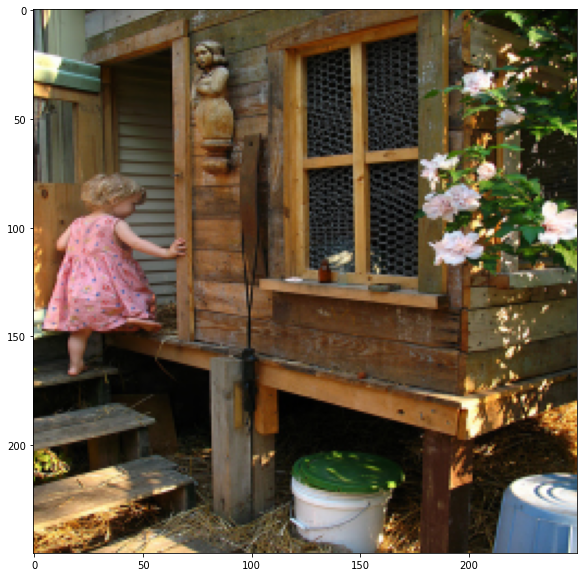

In [5]:
# Displaying resized image

plt.figure(figsize=(15,10))
plt.imshow(resizing(images_paths[0]))
plt.show()

**Let's process the captions for training**

In [6]:
# Reading data
captions_df = pd.read_csv("captions.txt")
captions_df

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 2 columns]

In [7]:
# Before processing, limiting the data for training (the value below can be changed as per user)
data_limiter = 30000  # out of 40,455

captions_df = captions_df.iloc[:data_limiter, :]

# Capturing the list of images to be kept from the list of directories of images
list_of_imgs_after_limiter = captions_df['image']
list_of_imgs_after_limiter = list(set(list(captions_df['image'])))

**Initialize functions that would process on the text of caption**

In [8]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [9]:
captions_df['caption_p'] = captions_df['caption'].apply(lambda x: preprocess_sentence(x))
captions_df

<ipython-input-9-e716665b7c78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  captions_df['caption_p'] = captions_df['caption'].apply(lambda x: preprocess_sentence(x))


image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
29995  3508882611_3947c0dbf5.jpg   
29996  3508882611_3947c0dbf5.jpg   
29997  3508882611_3947c0dbf5.jpg   
29998  3508882611_3947c0dbf5.jpg   
29999  3508882611_3947c0dbf5.jpg   

                                                 caption  \
0      A child in a pink dress is climbing up a set o...   
1                  A girl going into a wooden building .   
2       A little girl climbing into a wooden playhouse .   
3      A little girl climbing the stairs to her playh...   
4      A little girl in a pink dress going into a woo...   
...                                                  ...   
29995  A lady is running her dog through an agility c...   
29996  A large grey dog is jumping over a white hurdle .   
29997  A woman and a dog work through an agility cour...   
29998  a woman running around a course with a grey do...   
29999  Trainer runs her dog through training course w...   

                                               caption_p  
0      <start> a child in a pink dress is climbing up...  
1      <start> a girl going into a wooden building . ...  
2      <start> a little girl climbing into a wooden p...  
3      <start> a little girl climbing the stairs to h...  
4      <start> a little girl in a pink dress going in...  
...                                                  ...  
29995  <start> a lady is running her dog through an a...  
29996  <start> a large grey dog is jumping over a whi...  
29997  <start> a woman and a dog work through an agil...  
29998  <start> a woman running around a course with a...  
29999  <start> trainer runs her dog through training ...  

[30000 rows x 3 columns]

**Let's process the images for training**

In [10]:
# Converting to pd.Series for capturing image name
image_paths_series = pd.Series(images_paths)

# Initializing to store directories of 'kept' images
images_paths_limiter = []

# Storing the image directories here
for img in list_of_imgs_after_limiter:
    
    if sum(image_paths_series.str.contains(img)) != 0:
        images_paths_limiter.append(image_paths_series[image_paths_series.str.contains(img)].values[0])

In [11]:
# Initializing for storing processed values of each image
dict_images = {}

# Setting the resize shape
input_shape = (250,250)


def process_images_to_df(img_path):
    
    """
    Function that first gets the image name, processes on the image (as int type <= highly important to save space)
    and then assigns the processed values to the image name as key for the dictionary
    """
    
    # Extracting the image name
    title, ext = os.path.splitext(os.path.basename(img_path))
    
    # Processing the image to store its values as integer 
    padded_img = (resizing(img_path, input_shape)*255).astype(int)
    
    # Storing the data in dictionary
    dict_images[title+ext] = padded_img

In [12]:
# Running over each image directory obtained above
for single_img in tqdm(images_paths_limiter):

    process_images_to_df(single_img)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [02:13<00:00, 44.97it/s]


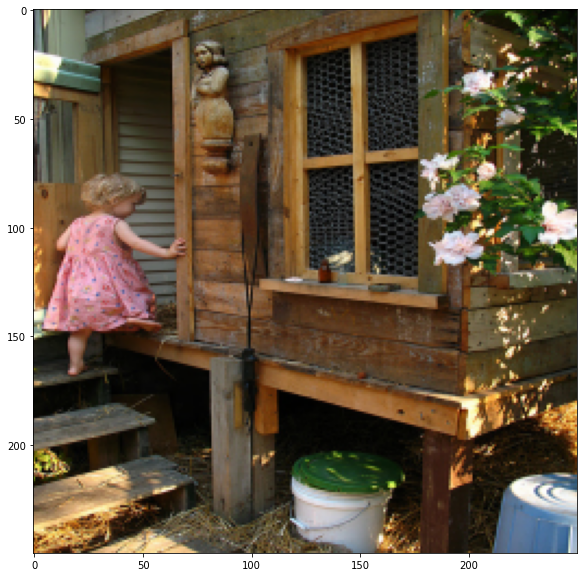

In [13]:
# Displaying the image to show that integrity of the image is maintained

plt.figure(figsize=(15,10))
plt.imshow(dict_images['1000268201_693b08cb0e.jpg'])
plt.show()

### Section 2 - Data Tokenization

**The processed text will be index-tokenized**

This means that for two texts such as -

1. I am here
2. He is here right now

the tokenized form would be -

1. [1, 2, 3, 0, 0]
2. [4, 5, 3, 6, 7]

Basically, the tokenized form would replace the word with a unique number that would represent that word.

- Notice the padding done at the end of sentence 1 (two 0's added). This will be done based on the maximum length of a sentence in a particular language

- Notice the repetiton of 3 in both tokenized forms which represent the word 'here' being repeated

In [14]:
# Function Initializing and Fitting on text
def create_tokenizer(lines):
    
    # Initialize tokenizer
    tokenizer = Tokenizer()
    
    # Fit the tokenizer on the text provided
    tokenizer.fit_on_texts(lines)
    
    # Return the tokenizer
    return tokenizer

# Creating tokenizer instances for all processed captions
tokenizer = create_tokenizer(captions_df['caption_p'])

In [15]:
# Function to compute maximum length of tokenized forms
def max_length(lines):
    
    # Compute the maximum length amongst all sentences in text
    return max([len(s.split()) for s in lines])

# Storing the maximum length for the captions
max_len = max_length(captions_df['caption_p'])
max_len

40

In [16]:
# We will also need the number of unique tokenization there are in any text. 
# This just computes the number of unique words found in the text

vocab_size = len(tokenizer.word_index) + 1
vocab_size

7423

In [17]:
# Function that will tokenize and pad the text
def encode_text(tokenizer, lines, length):
    
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    
    return padded

# Apply the tokenization and padding on processed captions
caption_tokenized = encode_text(tokenizer, captions_df['caption_p'], max_len)
caption_tokenized

array([[   3,    1,   43, ...,    0,    0,    0],
       [   3,    1,   19, ...,    0,    0,    0],
       [   3,    1,   38, ...,    0,    0,    0],
       ...,
       [   3,    1,   18, ...,    0,    0,    0],
       [   3,    1,   18, ...,    0,    0,    0],
       [   3, 1779,   70, ...,    0,    0,    0]])

In [18]:
# Storing all tokenized captions inside the dataframe
captions_df['caption_t'] = None

for i, caption in enumerate(caption_tokenized):
    
    captions_df['caption_t'][i] = caption
    
captions_df['caption_t']

<ipython-input-18-8b5a06161a80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  captions_df['caption_t'] = None
C:\Users\anmol\anaconda3\envs\tf_2.4\lib\site-packages\IPython\core\interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


0        [3, 1, 43, 4, 1, 96, 189, 7, 124, 49, 1, 413, ...
1        [3, 1, 19, 306, 66, 1, 205, 119, 2, 0, 0, 0, 0...
2        [3, 1, 38, 19, 124, 66, 1, 205, 2086, 2, 0, 0,...
3        [3, 1, 38, 19, 124, 5, 406, 20, 61, 2086, 2, 0...
4        [3, 1, 38, 19, 4, 1, 96, 189, 306, 66, 1, 205,...
                               ...                        
29995    [3, 1, 241, 7, 31, 61, 9, 33, 29, 1227, 358, 2...
29996    [3, 1, 53, 214, 9, 7, 45, 46, 1, 14, 553, 2, 0...
29997    [3, 1, 18, 8, 1, 9, 1406, 33, 29, 1227, 358, 2...
29998    [3, 1, 18, 31, 97, 1, 358, 10, 1, 214, 9, 45, ...
29999    [3, 1779, 70, 61, 9, 33, 1232, 358, 10, 58, 83...
Name: caption_t, Length: 30000, dtype: object

In [19]:
# Taking a final look at the dataframe
captions_df

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
29995  3508882611_3947c0dbf5.jpg   
29996  3508882611_3947c0dbf5.jpg   
29997  3508882611_3947c0dbf5.jpg   
29998  3508882611_3947c0dbf5.jpg   
29999  3508882611_3947c0dbf5.jpg   

                                                 caption  \
0      A child in a pink dress is climbing up a set o...   
1                  A girl going into a wooden building .   
2       A little girl climbing into a wooden playhouse .   
3      A little girl climbing the stairs to her playh...   
4      A little girl in a pink dress going into a woo...   
...                                                  ...   
29995  A lady is running her dog through an agility c...   
29996  A large grey dog is jumping over a white hurdle .   
29997  A woman and a dog work through an agility cour...   
29998  a woman running around a course with a grey do...   
29999  Trainer runs her dog through training course w...   

                                               caption_p  \
0      <start> a child in a pink dress is climbing up...   
1      <start> a girl going into a wooden building . ...   
2      <start> a little girl climbing into a wooden p...   
3      <start> a little girl climbing the stairs to h...   
4      <start> a little girl in a pink dress going in...   
...                                                  ...   
29995  <start> a lady is running her dog through an a...   
29996  <start> a large grey dog is jumping over a whi...   
29997  <start> a woman and a dog work through an agil...   
29998  <start> a woman running around a course with a...   
29999  <start> trainer runs her dog through training ...   

                                               caption_t  
0      [3, 1, 43, 4, 1, 96, 189, 7, 124, 49, 1, 413, ...  
1      [3, 1, 19, 306, 66, 1, 205, 119, 2, 0, 0, 0, 0...  
2      [3, 1, 38, 19, 124, 66, 1, 205, 2086, 2, 0, 0,...  
3      [3, 1, 38, 19, 124, 5, 406, 20, 61, 2086, 2, 0...  
4      [3, 1, 38, 19, 4, 1, 96, 189, 306, 66, 1, 205,...  
...                                                  ...  
29995  [3, 1, 241, 7, 31, 61, 9, 33, 29, 1227, 358, 2...  
29996  [3, 1, 53, 214, 9, 7, 45, 46, 1, 14, 553, 2, 0...  
29997  [3, 1, 18, 8, 1, 9, 1406, 33, 29, 1227, 358, 2...  
29998  [3, 1, 18, 31, 97, 1, 358, 10, 1, 214, 9, 45, ...  
29999  [3, 1779, 70, 61, 9, 33, 1232, 358, 10, 58, 83...  

[30000 rows x 4 columns]

In [20]:
# Just like done for images, creating a dictionary of captions containing 
    # tokenized caption as the value against the image name as key 
    
# (this cell is completely optional) implemented only to check decoder architecture
    
dict_captions = {}

for i in range(len(captions_df)):
    
    dict_captions[captions_df['image'][i]] = captions_df['caption_t'][i]

**Storing all processed data as pickle files**

In [21]:
# Storing dictionary of captions

with open("./processed_captions_dict_limiter.pkl", 'wb') as f:
    pickle.dump(dict_captions, f, protocol=4)

In [22]:
# Storing dataframe of captions

with open("./processed_captions_df_limiter.pkl", 'wb') as f:
    pickle.dump(captions_df, f, protocol=4)

In [23]:
# Storing dictionary of images

with open("./processed_images_dict_limiter.pkl", 'wb') as f:
    pickle.dump(dict_images, f, protocol=4)

### Section 3 - Defining the Model

**Perhaps the most difficult part to comprehend**

Let's start with loading all data (in case the kernel's instance has to be run again)

In [24]:
## Importing some relevant libraries

import os
import pandas as pd
import numpy as np

import glob
import pickle
import cv2

import matplotlib.pyplot as plt
from skimage.transform import resize

import unicodedata
import re

from tqdm import tqdm
import time

# Importing tensorflow packages
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Model, Input, Sequential

from tensorflow.keras.layers import Embedding, LSTM, Dense, Layer, \
                                    Activation, Softmax, Concatenate, TimeDistributed, Dropout

from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [25]:
dict_imgs = pickle.load( open( "./processed_images_dict_limiter.pkl", "rb" ) )

captions_df = pickle.load( open( "./processed_captions_df_limiter.pkl", "rb" ) )

dict_captions = pickle.load( open( "./processed_captions_dict_limiter.pkl", "rb" ) )

In [26]:
# This is a by-pass to let the model make use of more gpu memory when needed. I had to use it as it was throwing me an error
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

# The best training device for this model would be to use GPU. CPU will also work but may take a lot more time in training
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [27]:
# Parameters for decoder (same as done in previous section)

def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

tokenizer = create_tokenizer(captions_df['caption_p'])

def max_length(lines):
    return max([len(s.split()) for s in lines])

max_len = max_length(captions_df['caption_p'])

vocab_size = len(tokenizer.word_index) + 1

In [28]:
# The number of captions to be sent at a time to the model
batch_size = 25

# Shape of all Input image to be sent for feature extraction
input_shape = (250,250)

# Final embedding size to get output from the Encoder
# The target i.e. captions's tokenized text will be embedded with this length
enc_embed_size = tar_embed_size = 256

# Number of hidden cells in the LSTM layer that learns sequences of caption
tar_lstm_cells = 256

# Number of attention units (as Bahdanau Attention (soft-attention) is being applied)
attention_units = 256

#### Let us build up the concept slowly. Starting discussion with an Encoder-Decoder model **without any attention mechanism**

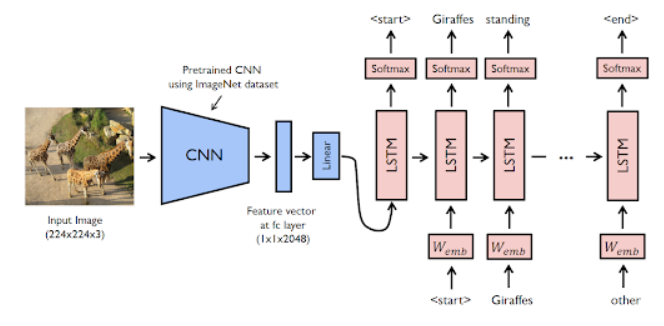

The blue cells denote the encoder and the red cells denote the decoder layers.

After the CNN model extracts features from the image, these are fed to the decoder (red hidden) layer that learns the sequences of caption along with the source features from the encoder.

The decoder layer then makes a projection layer which spits out a prediction vector of size V (vocabulary size of target language). The maximum probability value of this vector denotes the word that the model is predicting which is judged against what should be produced as a loss function.

Notice the \<start\> at the start of target input words which is the first word fed to the decoder model (representing the start of decoding) and the prediction at this point is the first word of caption. The last word of target input spits out \</end\> that would denote the end of prediction.

We have employed only one hidden layer in this notebook in the decoder.

**Teacher Forcing:**

We will implement teacher forcing during training. This means that the model is fed with the next word in the caption as an input to the decoder and that too in a sequential manner. In summary, it is the technique where the target word is passed as the next input to the decoder. Note that this won't and can not be implemented during inference

The inference, i.e. generating image caption once the model has been trained, would be a little different. Let's see how below-

Everything is the same except we don't know the target input to be fed to the model when you would be inferring (teacher forcing above).

In this case, the first prediction of \<start\> (Giraffes) is fed as an input of next target word to the model the produce the next word in the caption. The sequence continues until we hit \</end\> where the captioning stops.

Above figure is a type of greedy decoding since we are only looking at the word with the highest probability in the prediction vector. This is very basic seq2seq model. Adding the attention mechanism to it greatly enhances its performance. If you have understood the above architecture, move below to understand **Attention**

#### Let's now start with an Encoder-Decoder model **with Bahdanau attention mechanism**

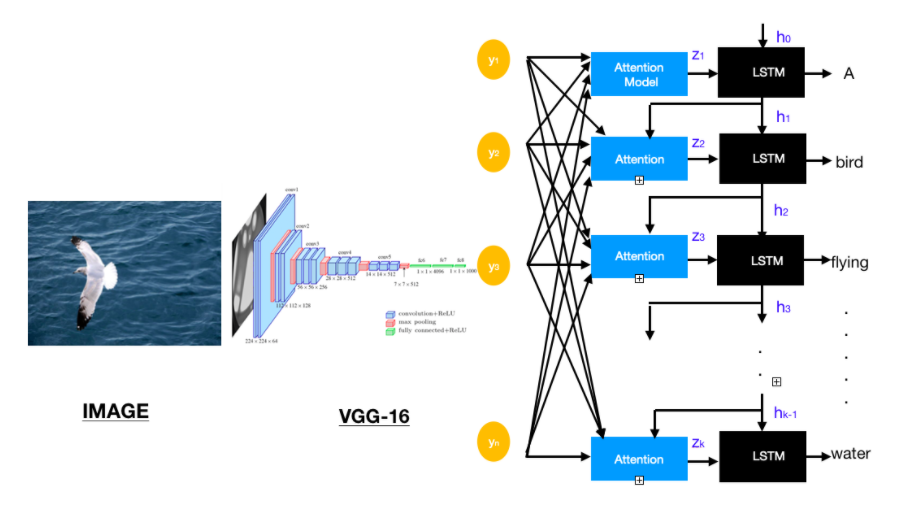

You will notice the addition of 'attention' to the above discussed model. Also, the picture has VGG-16 as the feature extractor but we are using Inception-V3 which is a pre-trained model

The calculation of the attention process hinges on the below formulae (note that soft attention is implemented) :-

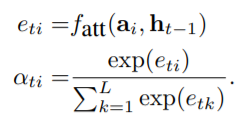

Above Figure:- Formula 4 and 1 respectively (for deriving attention weights ($ \alpha _{ti} $) )

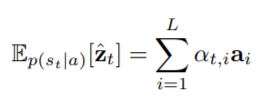

Above Figure:- Formula 2 (for computing context vector ($ \hat{z _{t}} $) )

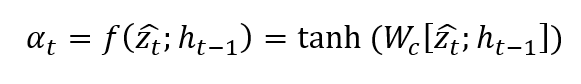

Above Figure:- Formula 3 (for computing the attention vector ($ \alpha _{t} $) )

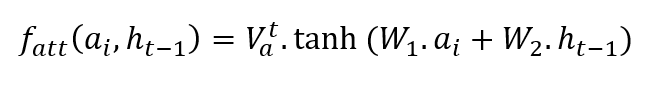

Above Figure:- Formula for computing attention score (Bahdanau Attention)

**Steps of Computation:-**

The attention computation happens at every decoder time step. It consists of the following stages:

1. The extracted features ($ a _i $) from the encoder are compared with each target hidden state ($ h _{t-1} $) to derive attention weights ($ \alpha _{ti} $).
2. Based on the attention weights ($ \alpha _{ti} $), we compute a context vector ($ \hat{z _{t}} $) as the weighted average of the source image features.
3. Then we combine the context vector ($ \hat{z _{t}} $) with the current target hidden state ($ h _{t-1} $) to yield the final attention vector ($ \alpha _{t} $)
4. The attention vector ($ \alpha _{t} $) is then fed as an input to the next time step (input feeding)

The way of comparing the input features with the current target hidden state has been researched and Bahdanau' additive style has been employed in this notebook (**Formula 4** and last formula in above). There are other comparative measures such as Luong's multiplicative style as well as their variations and combinations. The paper 'Show, Attend and Tell' also talks about a Hard Attention where the decoder focuses on a sinlge point as compared to an area of an image in soft attention.

The comparison gives out a score when all input features are compared with the current decoder hidden state. This score is fed to a softmax layer (**Formula 1**) that measures the score of the current hidden state against the input features (which are the attention weights).

The weights are then assessed with the input features so that the model focuses on where it should focus in identifying objects/actions in the input image (**Formula 2**). This produces a context vector that contains information where the context lies in the input features to generate the current word in the caption

The context vector is concatenated with the current target hidden state and then activated to get an attention vector (**Formula 3**) that encompasses all information of source input and for target input - everything upto the current decoder state.

Finally, the hidden state obtained during computation of attention vector is added as an input to the next word in decoder input so that the prior information is passed on in a sequential manner to its embedding and subsequent learning.

Notice the **teacher forcing** here during training when the target word is passed as the next input to the decoder. Again, as told earlier, it is an aspect only built-in during the training and the inference will act without it.

During the inference, everything is same except that teacher-forcing isn't implemented and the 'prediction' word from the model itself is fed as the next input to the decoder (along with the attention vector)

I believe that was a lot to take in. Here are some articles I referred when I tried to understand it all and I hope that these will be able to get you some more in-depth knowledge and insights -

1. Base Article - https://www.tensorflow.org/tutorials/text/image_captioning
2. Understanding 'Show, Attend & Tell' - https://arxiv.org/pdf/1502.03044.pdf
3. Understanding Pre-trained CNN - https://towardsdatascience.com/4-pre-trained-cnn-models-to-use-for-computer-vision-with-transfer-learning-885cb1b2dfc

**Let's begin with building the model**

##### Encoder Model

In [29]:
class Encoder(Model):
    
    # Intialize Encoder Model's Instance's parameters
    
    def __init__(self, input_shape, embed_size=enc_embed_size):
        
        super(Encoder, self).__init__()      
       
        # Initializing Inception-V3 pre-trained model on imagenet data to extract features
        self.cnn_feat_extractor = tf.keras.applications.InceptionV3(input_shape=(input_shape[0], input_shape[1], 3), include_top=False, weights='imagenet')
        
        # Feel free to change the pre-trained model above to any other for experimentation
        
        # Initializing a Dense layer
        self.dense_layer = Dense(embed_size, activation= 'relu')
      
    
    # Use 'call' function to make the Encoder Model produce actions that you would want it to
    
    # Takes the image as an input and produces extracted features as output
    def call(self, inp_img):
        
        # Extracting features from the CNN Model
        output = self.cnn_feat_extractor(inp_img)
        
        # Passing the output through a Dense Layer
        output = self.dense_layer(output)
        # output shape = [batch_size, cnn_final_layer's_dependent, cnn_final_layer's_dependent, enc_embed_size]
        
        # Reshaping the output
        output = tf.reshape(output, [output.shape[0], output.shape[1]*output.shape[2], output.shape[3]])
        # output shape = [batch_size, cnn_final_layer's_dependent^2, enc_embed_size]
        
        return output

In [30]:
# Initialize an instance of the Encoder model above with the defined parameters
enc_model = Encoder(input_shape=input_shape, embed_size=enc_embed_size)

# Test the working below

# Feed an input and see if the model produces an output
enc_out = enc_model(np.expand_dims(dict_imgs['1000268201_693b08cb0e.jpg'], axis=0)/ 255.)

In [31]:
enc_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dense (Dense)                multiple                  524544    
Total params: 22,327,328
Trainable params: 22,292,896
Non-trainable params: 34,432
_________________________________________________________________


##### Attention Layer

Here, we define the attention layer that takes all the outputs of the encoder and the current hidden state to generate attention weights and context vector. These will be subsequently utilized by the Decoder Model

Refer Formula 1, 2 & 4 to understand the working below. Formula 3 will be applied in the Decoder Model

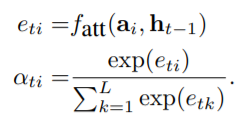

Above Figure:- Formula 4 and 1 respectively (for deriving attention weights ($ \alpha _{ti} $) )

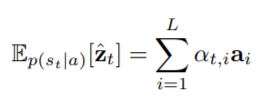

Above Figure:- Formula 2 (for computing context vector ($ \hat{z _{t}} $) )

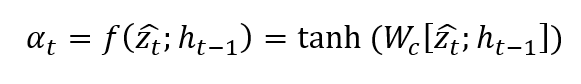

Above Figure:- Formula 3 (for computing the attention vector ($ \alpha _{t} $) )

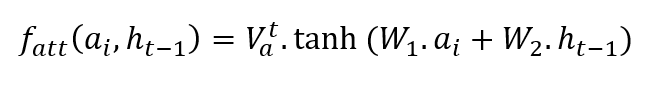

Above Figure:- Formula for computing attention score (Bahdanau Attention)

In [32]:
class Attention(Layer):

    def __init__(self, attention_units):
        
        super(Attention, self).__init__()
        
        self.W1 = Dense(attention_units) # Initialize a Dense layer with neurons = number of attention_units
        self.W2 = Dense(attention_units) # Initialize a Dense layer with neurons = number of attention_units
        self.V = Dense(1)                 # Initialize a Dense layer with neurons = 1
    
    
    # This function is executed when an instance of this class is called
    
    # hidden = output of the current target state
    # output = all outputs of the encoder model
    def call(self, hidden, output, first=True):
        
        # the shape of the hidden input is extended i.e. from [batch_size, tar_lstm_cells] to [batch_size, 1, tar_lstm_cells]
        if first:
            hidden_extended = tf.expand_dims(hidden[0], axis=1)
        else:
            hidden_extended = tf.expand_dims(hidden, axis=1)
        
        # hidden_extended shape = [batch_size, 1, target_lstm_cells]
        # output shape = [batch_size, cnn_final_layer's_dependent^2, enc_embed_size]

        # Formula 4 i.e. Bahdanau Attention applied here to generate a score
        score = self.V(tf.nn.tanh(self.W1(hidden_extended) + self.W2(output)))
        # score shape = [batch_size, cnn_final_layer's_dependent^2, 1] 
        
        # Formula 1 applied here to get the attention weights (notice axis = 1) 
        # since we have to compute a weight to each source input, the softmax is applied at axis=1 of score
        atn_weights = tf.nn.softmax(score, axis=1)
        # attention_weights shape = [batch_size, cnn_final_layer's_dependent^2, 1]
        
        # A part of Formula 2 is applied where we multiple the attention weights with the outputs from the encoder model
        context_vector = atn_weights*output
        # context_vector shape = [batch_size, cnn_final_layer's_dependent^2, enc_embed_size]

        # The second part of Formula 2 where the multiplied product is summed against each source input
        # the axis=1 here has the same reasoning wherein we want to sum the values to get one vector for each source input
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # context_vector shape = [batch_size, enc_embed_size]
        
        # return the context_vector and the attention_weights generated from the above operations
        return context_vector, atn_weights

##### Decoder Model

This is the most difficult architectural formulation of the model. Please look at the operations step-by-step

Both Bahdanau Attention and Decoder operations will be performed in this class to generate predictions. Formula 3 of the Attention mechanism discussed above will be implemented in this class as well

In [33]:
class Decoder(Model):
                    
    # Providing parameters to decoder to generate layers
    def __init__(self, batch_size, tar_embed_size, tar_vocab_size, tar_lstm_cells, attention_units):
        
        super(Decoder, self).__init__()
        
        self.batch_size = batch_size
        self.tar_embed_size = tar_embed_size # Initializing size that the Embedding layer outputs
        self.tar_vocab_size = tar_vocab_size # Initializing the vocabulary size of target text
        self.tar_lstm_cells = tar_lstm_cells # Initializing the number of hidden cells in the lstm layer
        self.attention_units = attention_units  # Initializing the number of units for the attention layer
        
        
        # Initializing an Embedding layer here
        
        # vocab_size given as the range within which it has to work
        # embed_size denoting the embedding output size
        self.dec_embedding = Embedding(self.tar_vocab_size, self.tar_embed_size, trainable=True)
        
            
        # Initializing an LSTM layer here
        
        # lstm_cells denotes the number of hidden cells inside the layer
        # return_sequences and return_state give out output of LSTM cell and its state at each time step
        self.lstm = LSTM(self.tar_lstm_cells, return_sequences=True, return_state=True)
        
        
        # Initializing an Attention layer here
        
        # attention_units denotes the number of neurons inside the layer
        self.attention = Attention(self.attention_units)
        
        # Initializing a Dense layer
        self.dense = Dense(self.attention_units)
        
        # Initializing a Dropout layer as a regularizer
        self.dropout = Dropout(0.5)
        
        
        # Initializing a Final Dense layer here
        
        # takes the same number or neurons as the vocabulary size of target text (producing a probability value for each word)
        self.final_layer = Dense(self.tar_vocab_size)

    
    # This call function is executed when an instance of this class is called
    
    # x = input to the decoder
    # hidden = output of the current target state
    # enc_output = all outputs of the encoder model
    def call(self, x, hidden, enc_output, first=True):
        
        
        # Applying the attention on hidden state of current target state and output from the encoder
        context_vector, attention_weights = self.attention(hidden, enc_output, first)
        # context_vector shape = [batch_size, enc_embed_size]
        # attention_weights shape = [batch_size, cnn_final_layer's_dependent^2, 1]
        
        
        # Apply embeddings on the decoder input
        emb_output = self.dec_embedding(x)
        # emb_output shape = [batch_size, 1, tar_embed_size]

        
        # Performing part 1 of Formula 3 i.e. concatenation of context_vector and embedding output
        # context_vector shape is expanded first from [batch_size, enc_embed_size] to [batch_size, 1, enc_embed_size]
        x_context = tf.concat([tf.expand_dims(context_vector, axis=1), emb_output], axis=-1)
        # x_context shape = [batch_size, 1, tar_embed_size+enc_embed_size]
        
        
        # Performing part 2 of Formula 3 i.e. activating it using as LSTM layer
        # Running the x_context through as LSTM layer that learns the sequences
        tar_lstm_output, tar_state_h, tar_state_c = self.lstm(x_context)
        # lstm_output shape = [batch_size, 1, tar_lstm_cells]
        
        # Passing the lstm output through a dense layer
        tar_lstm_output = self.dense(tar_lstm_output)
        
        # Passing the lstm output through a dropout layer
        tar_lstm_output = self.dropout(tar_lstm_output)
        
        
        # The output is reshaped here in order to be fed to the final Dense layer
        tar_lstm_output = tf.reshape(tar_lstm_output, shape=(-1, tar_lstm_output.shape[2]))
        # tar_lstm_output_reshaped shape = [batch_size, tar_lstm_output]
        
        
        # the final dense layer outputs a score for each word that may be considered as a prediction
        # for this reason, the complete target vocabulary is provided as number of neurons to this layer
        word_prob = self.final_layer(tar_lstm_output)
        # word_prob shape = [batch_size, tar_vocab_size]

        # return the word predictions, last output from the decoder LSTM and the attention_weights
        return word_prob, tar_state_h, attention_weights
    

    # This function is meant to initialize the hidden weights of the lstm layer inside the decoder

    def initialize_hidden_states(self):

        # There are two sets of initializations made - 
                        # for the hidden cell input (h at t-1) and hidden cell state (c at t-1)
        return [tf.zeros([self.batch_size, self.tar_lstm_cells]), tf.zeros([self.batch_size, self.tar_lstm_cells])]

In [34]:
# Initialize an instance of the Encoder model above with the defined parameters
dec_model = Decoder(batch_size = batch_size, tar_embed_size = tar_embed_size, \
                    tar_vocab_size = vocab_size, tar_lstm_cells = tar_lstm_cells, \
                    attention_units = attention_units)

# Test the working below

dec_hidden_s = dec_model.initialize_hidden_states()

# Feed an input and see if the model produces an output
w, s, wt = dec_model(tf.expand_dims([np.expand_dims(dict_captions['1000268201_693b08cb0e.jpg'], axis=0)[0][0]] * batch_size, 1), \
                     dec_hidden_s, enc_out)

In [35]:
dec_model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1900288   
_________________________________________________________________
lstm (LSTM)                  multiple                  787456    
_________________________________________________________________
attention (Attention)        multiple                  131841    
_________________________________________________________________
dense_4 (Dense)              multiple                  65792     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  1907711   
Total params: 4,793,088
Trainable params: 4,793,088
Non-trainable params: 0
_________________________________________________

We are finally finished with setting up the Encoder and Decoder Model Classes

We can now begin setting up the loss function that will be monitored and reduced as the training progresses

In [36]:
# Adam optimizer will be implemented
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# An instance of the SparseCategoricalCrossentropy Loss with some required arguments that define how it has to perform
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# from_logits - unnormalized predictions passed (notice no softmax applied in the final layer)
# reduction = 'none' - returns the full array of the per-sample losses in the batch

In [37]:
# Initializing Loss function here
def loss_function(real, pred):
    
    # mask shape = [batch_size, ]
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # tf.math.equal returns True when values are equal to 0
                                                #tf.math.logical_not inverses the above (True<==>False)
        
    # The mask is meant to only take losses where there is an actual word that exists i.e.
    # not for cases where the padding has been placed to put 0 as a token

    # Compute loss using real and pred values    
    loss_ = loss_object(real, pred)
    # loss_ shape = [batch_size, ]
    
    # casts mask variable as a tf loss type variable
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # multiplies loss with mask (this operation will nullify any loss values where the padding has been put in place)
    loss_ *= mask
    # loss_ shape = [batch_size, ]

            # tf.reduce_mean computes the mean loss
    return tf.reduce_mean(loss_)

In [38]:
# Some other helper functions initialized below


def shuffler(captions_df):
    
    # Function for shuffling the dataset for fitting the model with (implemented every epoch)
    
    n_elem = captions_df.shape[0]
    indices = np.random.choice(n_elem, size=n_elem, replace=False)

    return captions_df.iloc[indices, :]


def generator_captions(batch_number, captions_df):
    
    # Function for generating a batch of data from the dataset provided
    
    return (captions_df.iloc[batch_number*batch_size: batch_number*batch_size+batch_size])


def generator_images(img_names):
    
    # Function to collect and pass the processed images as a numpy array
    
    array_of_imgs = []
    
    for img_name in img_names:
        array_of_imgs.append(dict_imgs[img_name])
        
    return np.array(array_of_imgs)
      
    
def caption_tensor_gen(cap):
    
    # Function to collect and pass the captions as a tensorflow tensor
    
    cap_list = []

    for val in cap:
        cap_list.append(list(val))
        
    return tf.convert_to_tensor(cap_list)

### Section 4 - Training the Model

Now that all moving parts of model are finished, we can now proceed with training the model

In [39]:
# Function to call for training every batch

@tf.function  # Decorator - Compiles the function below into a callable TensorFlow graph
def train_step(inp, targ, epoch, train=True): # runs for a single batch
    
    # initialize loss as 0 for the batch
    loss = 0
    
    # uses gradient tape so that differentiation takes place accordingly to update gradient and weights
    with tf.GradientTape() as tape:
        
        # get the output from encoder model
        enc_output = enc_model(inp)
        # enc_output shape = [batch_size, cnn_final_layer's_dependent^2, enc_embed_size]
        
        # assign enc_hidden state as dec_hidden state
        dec_hidden = dec_model.initialize_hidden_states()
        # dec_hidden shape = [batch_size, tar_lstm_cells]
        
        # for each sample in batch take starting index as the same as 'start' taken from target tokenizer
        # use the above as the first input to the decoder model
        dec_input = tf.expand_dims([tokenizer.word_index['start']] * batch_size, 1)
        # dec_input shape = [batch_size, 1]

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]): # run for the complete length of target outputs
            
            # passing enc_output to the decoder
            if t == 1:   
                predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_output, first=True)
            else:
                predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_output, first=False)

            # compute loss for the word predicted (t) after the previous word supplied for all samples
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing (take the next word as an input to the decoder model)
            dec_input = tf.expand_dims(targ[:, t], 1)
            # dec_input shape = [batch_size, 1]
    
    
    # computing batch loss by dividing the total loss with the length of target
    batch_loss = (loss / int(targ.shape[1]))
    
    
    if train==True:

        # As the loss has now been computed, let's notify the model to optimize the gradients i.e. train the model

        # collecting all decoder variables to compute gradient
        variables = dec_model.trainable_variables
        
        # For training both encoder and decoder, uncomment below line and comment above line 
        # variables = enc_model.trainable_variables + dec_model.trainable_variables

        # compute the gradients. (loss is differentiated against variables)
        gradients = tape.gradient(loss, variables)

        # Applies gradients to variables
        optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [43]:
# The training will now be carried here

EPOCHS = 100 # Initialize the number of epochs to run

# Setting the patience for cutting off the training (if loss is not reducing)
patience = 3
counter = 0

# To store loss of each epoch
train_loss_history = []

# Computing number of batches
number_of_batches = captions_df.shape[0]//batch_size
    
# Splitting the dataset at the end to form full batches
captions_df_split = captions_df[:number_of_batches*batch_size]
    
    
for epoch in range(EPOCHS):
    
    start = time.time()

    # total loss is 0 for the epoch
    total_loss = 0
        
    # Shuffle the dataset here
    captions_df_split_shuffled = shuffler(captions_df_split).reset_index(drop=True)
    
    # run for all batches of inputs and targets
    for batch_number in range(number_of_batches):
        
        # Generate the batch to be sent to the model for training
        
        captions = generator_captions(batch_number, captions_df_split_shuffled)[['image', 'caption_t']].values
        
        targ = caption_tensor_gen(captions[:, 1])
        
        inp = tf.convert_to_tensor(generator_images(captions[:, 0]) / 255.)

        # apply the train step function declared earlier and get the loss for the batch
        batch_loss = train_step(inp, targ, epoch)

        # add the batch loss to total loss for the epoch
        total_loss += batch_loss

        # printing some summaries inside the loop
        if batch_number % 200 == 0:
            
            print('Epoch {} |---| Batch {} |---| Loss {:.4f}'.format(epoch + 1,
                                                       batch_number,
                                                       batch_loss.numpy()))
    
    # Appending the total loss of the epoch here
    train_loss_history.append(total_loss / number_of_batches)
    
    # printing epoch summaries here
    print('Epoch {} |---| Train Loss {:.4f}'.format(epoch + 1,
                                      total_loss / number_of_batches))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    # Saving model's weights at each epoch
    print("Saving Weights Now")
    enc_model.save_weights('./weights/enc_weights_WithoutEncTrain_'+str(epoch)+'.h5')
    dec_model.save_weights('./weights/dec_weights_WithoutEncTrain_'+str(epoch)+'.h5')
    print("Weights have been saved\n")
    
        
    # The below set of checks are made to ensure that loss is reducing with each epoch. 
    # If it is not, we break out of the loop stopping the training
    if epoch >= 1:
        if train_loss_history[-1] >= train_loss_history[-2]:
            counter+=1
            if counter >= patience:
                print("breaking now as loss isn't reducing")
                break
        else:
            counter=0

Epoch 1 |---| Batch 0 |---| Loss 0.3151
Epoch 1 |---| Batch 200 |---| Loss 0.3733
Epoch 1 |---| Batch 400 |---| Loss 0.3518
Epoch 1 |---| Batch 600 |---| Loss 0.3544
Epoch 1 |---| Batch 800 |---| Loss 0.3717
Epoch 1 |---| Batch 1000 |---| Loss 0.3960
Epoch 1 |---| Train Loss 0.4073
Time taken for 1 epoch 329.5262031555176 sec

Saving Weights Now
Weights have been saved

Epoch 2 |---| Batch 0 |---| Loss 0.3794
Epoch 2 |---| Batch 200 |---| Loss 0.4106
Epoch 2 |---| Batch 400 |---| Loss 0.3792
Epoch 2 |---| Batch 600 |---| Loss 0.4705
Epoch 2 |---| Batch 800 |---| Loss 0.4300
Epoch 2 |---| Batch 1000 |---| Loss 0.3859
Epoch 2 |---| Train Loss 0.4022
Time taken for 1 epoch 326.81159496307373 sec

Saving Weights Now
Weights have been saved

Epoch 3 |---| Batch 0 |---| Loss 0.3833
Epoch 3 |---| Batch 200 |---| Loss 0.3038
Epoch 3 |---| Batch 400 |---| Loss 0.4163
Epoch 3 |---| Batch 600 |---| Loss 0.4044
Epoch 3 |---| Batch 800 |---| Loss 0.4112
Epoch 3 |---| Batch 1000 |---| Loss 0.4027
Ep

KeyboardInterrupt: 

### Section 5 - Inference from the Model

**Firstly, let's store model weights**

As described earlier, the inference will happen with feeding the predicted value from the previous time step to the next time step. The inference will be performed below

### Greedy Search

**Greedy Search is the most basic inference algorithm. It takes the word with the highest probability at each output from the decoder input. This word is then fed to the next time step of the decoder to predict the next word until we hit the 'end' signal**

In [44]:
# Helper function to convert the sequence of word-ids to words using the caption's tokenizer
def indices_to_sentences(indices, evaluation='beam'):
    
    all_sentences = []
    
    for single_seq in indices:
        
        result = ''
        
        # Run this if evaluation type set is beam
        if evaluation != 'beam':
            
            for i in single_seq[:-1]:
                
                if i==0:
                    break

                result += tokenizer.index_word[i] + ' '

            all_sentences.append(result)
        
        # Run this if evaluation type set is not beam
        else:

            for i in single_seq[0][:-1]:

                result += tokenizer.index_word[i] + ' '

            all_sentences.append(result)
            
    return all_sentences

In [45]:
# Function to translate the sentence

def evaluate(img_path):

    # process the image first    
    padded_img = np.expand_dims((resizing(img_path)*255).astype(int) / 255. , axis=0)
    
    # Convert the datatype to tensorflow-tensor
    inputs = tf.convert_to_tensor(padded_img)
  
    # initialize to store the result
    result = ''
    
    # get the output of the encoder using initialized weights
    enc_output = enc_model(inputs)

    # initialize decoder hidden weights
    dec_hidden = [tf.zeros([1, tar_lstm_cells]), tf.zeros([1, tar_lstm_cells])]
    
    # intialize the decoder input as the tokenized form of 'start'
    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
    
    # run for the maximum length of target language
    for t in range(max_len):
        
        if t == 0:   
            predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_output, first=True)
        else:
            predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_output, first=False)

        # get the argument(token) for the word that is given maximum probability score by the model
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        
        # check if 'end' is hit on the outputted word from decoder model
        if tokenizer.index_word[predicted_id] == 'end':
            
            # Print the image
            plt.figure(figsize=(15,10))
            plt.imshow(tf.reshape(padded_img, [padded_img.shape[1], padded_img.shape[2], padded_img.shape[3]]))
            plt.show()
            
            # Return the predicted caption
            return result
        
        # Get the word based on the token and add to result
        result += tokenizer.index_word[predicted_id] + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    
    # Print the image
    plt.figure(figsize=(15,10))
    plt.imshow(tf.reshape(padded_img, [padded_img.shape[1], padded_img.shape[2], padded_img.shape[3]]))
    plt.show()
    
    # Return the predicted caption
    return result

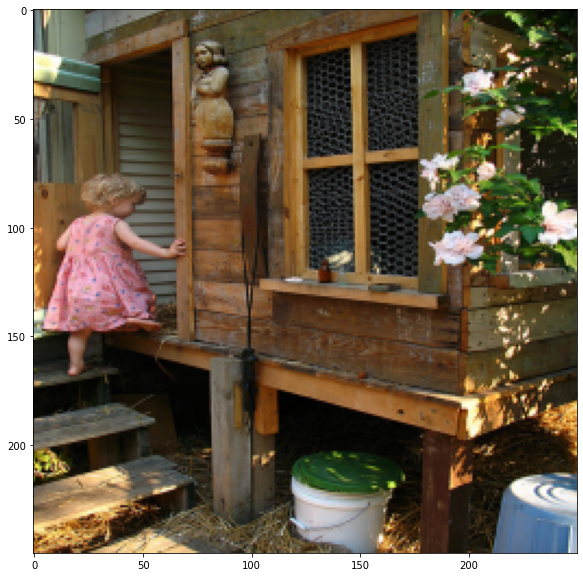

'a little girl climbing a wooden playhouse '

In [46]:
evaluate('./Images/1000268201_693b08cb0e.jpg')

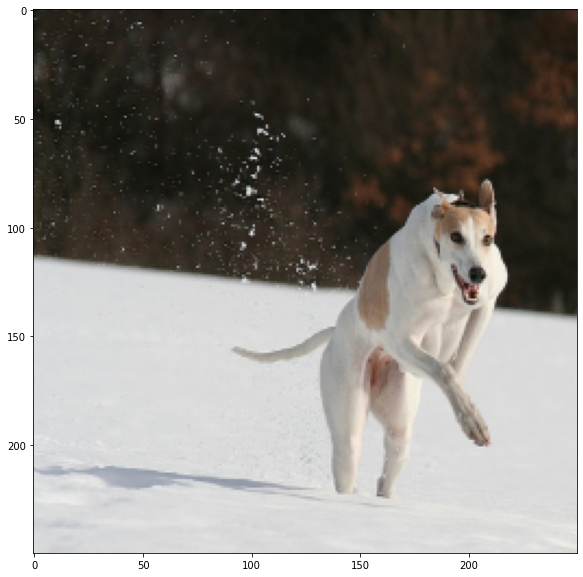

'a dog running through the snow '

In [47]:
evaluate(images_paths[10])

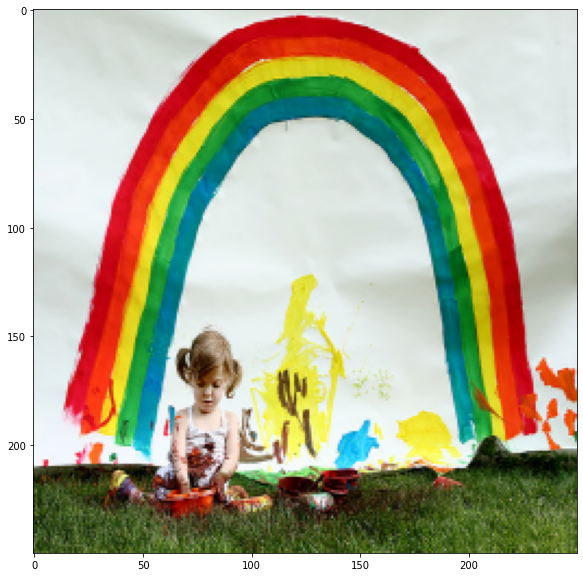

'a little girl in a pool '

In [48]:
evaluate(images_paths[2])

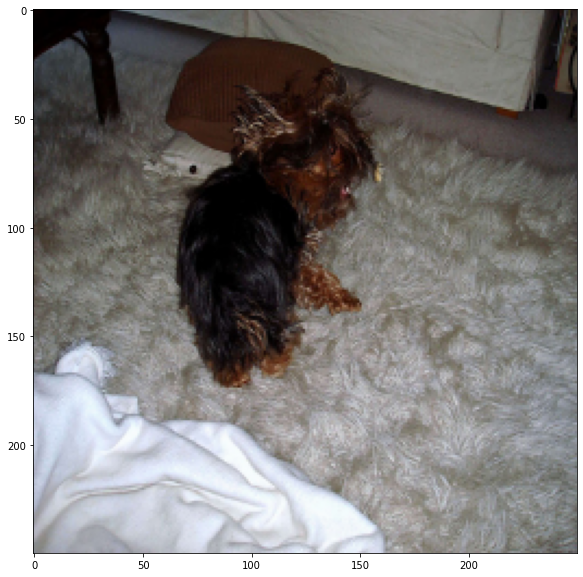

'a small dog with a shaggy rug '

In [49]:
evaluate(images_paths[200])

### Beam Search

**Beam Search is slightly complicated. It produces K (which is user-defined) number of translations based on highest conditional probabilities of the words**



Suppose we take k=3 (see below pic; reference:- https://www.youtube.com/watch?v=RLWuzLLSIgw&t=360s&ab_channel=DeepLearningAI)



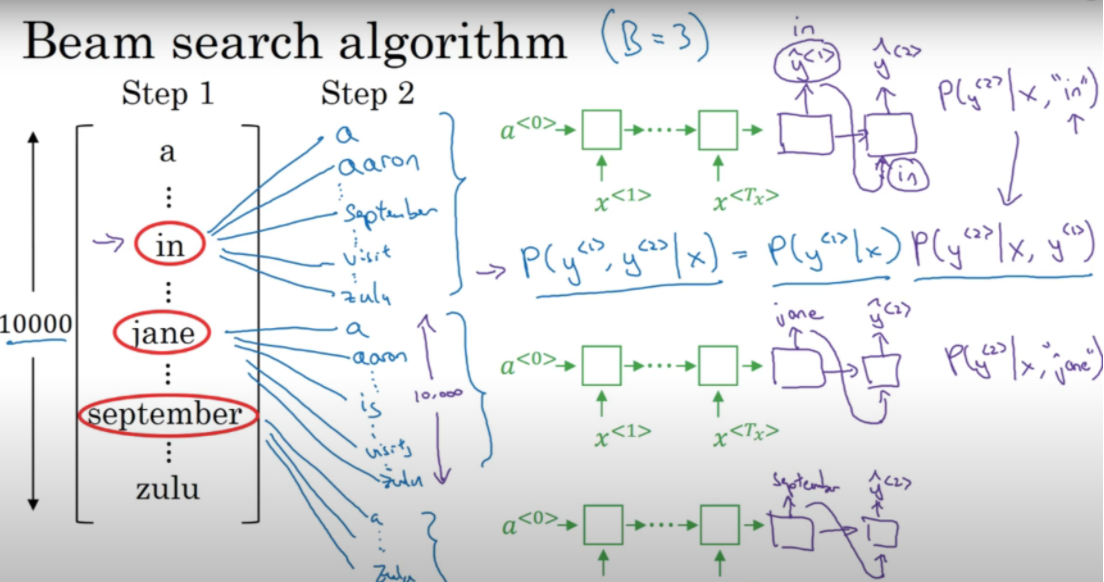

In beam search, we take the top k words as a possibility instead of the word with highest probability. In above pic, in step 1 we see three words - (in, jane, september) as three possible translated words that have the highest probability out of the 10,000 vocabulary of words.

In step 2, for each of the previous word, we pick another top 3 words with highest probability. But this probability calculation is now conditional to the previous word and is calculated based on the probability formula given in the picture.

But the probability calculation will be slightly modified by taking its negative log (log being monotonous will not impact the values; this trick makes the formula to add the probabilities instead of multiplying them to avoid underflow). See modified formula below -

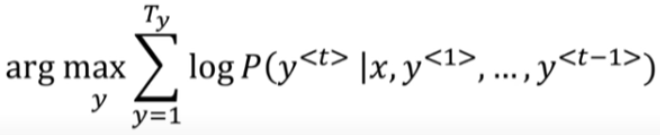

Once we have the 9 probabilities (k x k), we filter for the top 3 highest and then carry them forward to step 3 and so on.

One thing to note here is that there are k decoder models running here for reference for each word found in step 1. Let's discuss more about it with the pic below

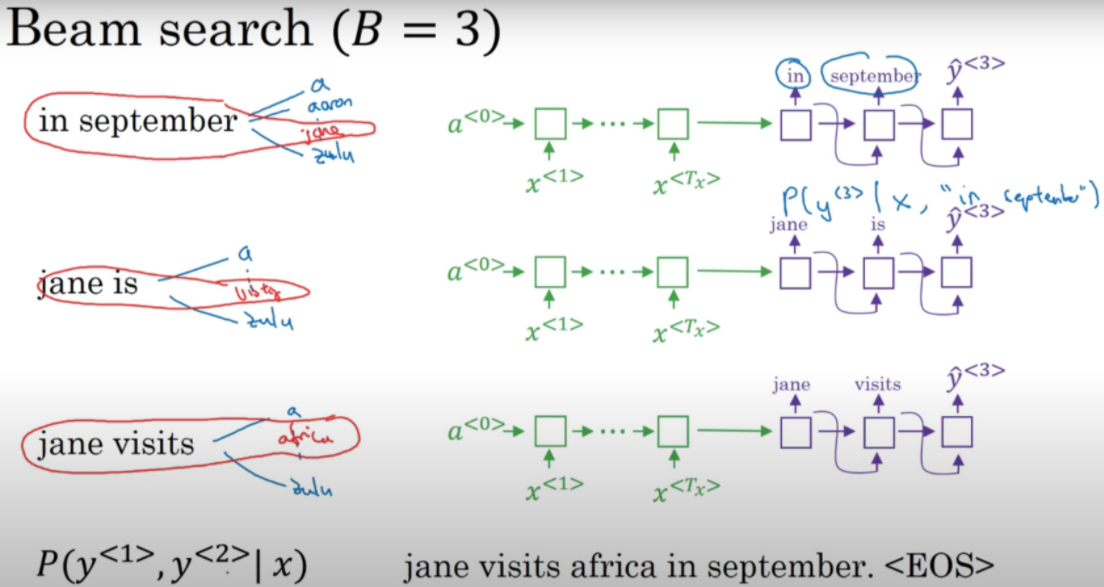

We see three decoder models that take the previous word as an input and then predicts the next word. Now some cases might arise here-

1. The top three probabilities might come out of one or two previous words and so the decoder model(s) that don't have the highest probability get cut off. This is advantageous as we are concerned with the highest conditional probability of the entire sentence.
2. A sentence progression can hit the 'end' signal before others and thus we get one possible translation of the sentence. The decoder model at this point might get cut off depending if it has more sequence progressions arising out of it.

Both cases above are considered in the algorithm formulation below. The above points also helps to understand the working behind Beam Search

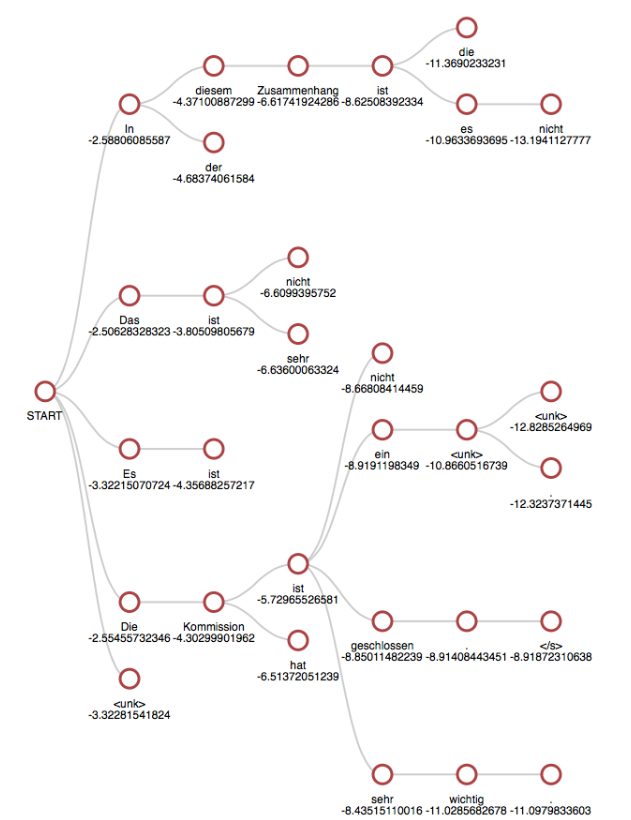

Above is an illustration of beam search with k=5 in translation to German. Notice 5 nodes at each vertical segment.

source:- https://medium.com/the-artificial-impostor/implementing-beam-search-part-1-4f53482daabe

In [50]:
# Function to get indices of k largest values in a 2-D matrix
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [51]:
# First function processing the Step-2 (that hits after Step-1)

def prelim_function_performing_beam_search(dec_hidden, pred_topk_word_ids, pred_topk_log_probs, enc_out, k):

    # Initialzing some empty lists
    
    # To store log probability for the the k*k combinations
    log_prob_for_beam = []
    
    # To store word_ids for each of the k*k combinations from the target language tokenizer
    word_ids_for_beam = []
    
    # To store the hidden layers of the k decoders (as each will have its own sequence progression)
    hidden_layers = []
    
    
    # Run for k i.e. number of beam searches to produce
    for i in range(k):
        
        # get the input to feed to the decoder model using previous prediction's word id
        dec_input = tf.expand_dims([pred_topk_word_ids[i]], 0)

        # get the output of the decoder based on the outputs provided from encoder,
                                                # input taken previous prediction and
                                                # the decoder's hidden layer
        cur_step_preds, hidden_layer, _ = dec_model(dec_input, dec_hidden, enc_out, first=False)
        
        # append the hidden layers from this decoder (each word from step 2 will have its own decoder hidden layer)
        hidden_layers.append(hidden_layer)
        
        # Get the normalized predictions using Softmax
        cur_step_pred_normalized = tf.nn.softmax(cur_step_preds)
        # pred_normalized shape = [1, tar_vocab_size]

        # Sort the predictions in descending order
        cur_step_pred_normalized_sorted = tf.sort(cur_step_pred_normalized, direction='DESCENDING').numpy()[0]
        # pred_normalized_sorted shape = [1, tar_vocab_size]

        # Converting normalized prediction to numpy data-type
        cur_step_pred_normalized = cur_step_pred_normalized.numpy()

        # Taking the top k predictions
        cur_step_pred_topk_probs = cur_step_pred_normalized_sorted[:k]
        
        # getting the word_ids of the tok k predictions based on their index positions
        cur_step_pred_topk_word_ids = np.array([np.argwhere(cur_step_pred_normalized==x)[0][1] 
                                                for x in cur_step_pred_topk_probs])
        
        # Storing the word_ids here
        word_ids_for_beam.append(cur_step_pred_topk_word_ids)
        
        # Computing the negative log combined probability of previous word and current step's top k predictions
        current_step_topk_probs = pred_topk_log_probs[i] - np.log(cur_step_pred_normalized_sorted[:k])
        
        # Storing the negative log combined probability here
        log_prob_for_beam.append(current_step_topk_probs)

    # Converting the lists to arrays for working with numpy functions
    word_ids_for_beam = np.array(word_ids_for_beam)
    
    log_prob_for_beam = np.array(log_prob_for_beam)
    
    # Inverting the log_prob to inverse the relationship between them (lowest becomes highest and vice-versa)
    log_prob_for_beam_inv = 1/log_prob_for_beam
    
    # Getting the indices of the 2-d matrix: log_prob_for_beam_inv (for top k highest values)
    indices_where_prob_max = k_largest_index_argsort(log_prob_for_beam_inv, k=k)
    
    # Sort my index array based on second column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,1])]
    
    # Sort my index array based on first column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,0])]
    
    # The above sorting is a trick that will sort the first column values in ascending order and then the second column
    # so that one gets - [[0 2], [1 1]] and not [[1 1], [0 2]]
    
    
    # Some hidden layers might get cut off as there could be top predictions only from l decoder layers out of k (l<k)
    # So, we store them separately in case this happens
    
    new_hidden_layers = []
    
    for i in indices_where_prob_max[:,0]:
        new_hidden_layers.append(hidden_layers[i])
        
    # with the same logic, we store the word ids and their log probabilities to feed them to the next step

    next_step_word_ids = word_ids_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]

    next_step_topk_log_probs = log_prob_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]
    
    
    # As we have new words now, we store them as sequences
    sequences = [[] for i in range(k)]
    
    for i, word_id in enumerate(pred_topk_word_ids):
        sequences[i].append(word_id)
    
    
    return sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k


In [52]:
# Second function processing all steps after Step-2

def function_performing_beam_search(hidden_ls, pred_topk_word_ids, pred_topk_log_probs, enc_out, passing_sequences, k):
    
    # Initialzing some empty lists
    
    # To store log probability for the the k*k combination
    log_prob_for_beam = []
    
    # To store word_ids for each of the k*k combinations from the target language tokenizer
    word_ids_for_beam = []
    
    # To store the hidden layers of the k decoders (as each will have its own sequence progression)
    hidden_layers = []
    
    # Run for k (here k might not be equal to the original k as some sequences might have ended)
    for i in range(k):
        
        # get the input to feed to the decoder model using previous prediction's word id
        dec_input = tf.expand_dims([pred_topk_word_ids[i]], 0)

        # get the output of the decoder based on the outputs provided from encoder,
                                                # input taken previous prediction and
                                                # the decoder's hidden layer (its own)
        cur_step_preds, hidden_layer, _ = dec_model(dec_input, hidden_ls[i], enc_out, first=False)
        
        # append the hidden layers from this decoder (each word will have its own decoder hidden layer)
        hidden_layers.append(hidden_layer)
        
        # Get the normalized predictions using Softmax
        cur_step_pred_normalized = tf.nn.softmax(cur_step_preds)
        # pred_normalized shape = [1, tar_vocab_size]

        # Sort the predictions in descending order
        cur_step_pred_normalized_sorted = tf.sort(cur_step_pred_normalized, direction='DESCENDING').numpy()[0]
        # pred_normalized_sorted shape = [1, tar_vocab_size]

        # Converting normalized prediction to numpy data-type
        cur_step_pred_normalized = cur_step_pred_normalized.numpy()

        # Taking the top k predictions
        cur_step_pred_topk_probs = cur_step_pred_normalized_sorted[:k]
        
        # getting the word_ids of the tok k predictions based on their index positions
        cur_step_pred_topk_word_ids = np.array([np.argwhere(cur_step_pred_normalized==x)[0][1] 
                                                for x in cur_step_pred_topk_probs])
        
        # Storing the word_ids here
        word_ids_for_beam.append(cur_step_pred_topk_word_ids)
        
        # Computing the negative log combined probability of previous word and current step's top k predictions
        current_step_topk_probs = pred_topk_log_probs[i] - np.log(cur_step_pred_normalized_sorted[:k])

        # Storing the negative log combined probability here
        log_prob_for_beam.append(current_step_topk_probs)
    
    # Converting the lists to arrays for working with numpy functions
    
    word_ids_for_beam = np.array(word_ids_for_beam)
    
    log_prob_for_beam = np.array(log_prob_for_beam)
    
    # Inverting the log_prob to inverse the relationship between them (lowest becomes highest and vice-versa)
    log_prob_for_beam_inv = 1/log_prob_for_beam
    
    # Getting the indices of the 2-d matrix: log_prob_for_beam_inv (for top k highest values)
    indices_where_prob_max = k_largest_index_argsort(log_prob_for_beam_inv, k=k)
    
    # Sort my index array based on second column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,1])]
    
    # Sort my index array based on first column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,0])]
    
    
    # Some hidden layers might get cut off as there could be top predictions only from l decoder layers out of k (l<k)
    # So, we store them separately in case this happens
    
    new_hidden_layers = []
    
    for i in indices_where_prob_max[:,0]:
        new_hidden_layers.append(hidden_layers[i])

    # with the same logic, we store the word ids and their log probabilities to feed them to the next step
    
    next_step_word_ids = word_ids_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]

    next_step_topk_log_probs = log_prob_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]
    
    
    # Now, we append the word_ids to the sequences we have to progress
    for i, word_id in enumerate(next_step_word_ids):
        passing_sequences[i].append(word_id)
        
    
    return passing_sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k

In [53]:
# Function to translate the sentence with beam search (k)

def evaluate_with_beam(img_path, k):
    
    # process the image first    
    padded_img = np.expand_dims((resizing(img_path)*255).astype(int) / 255. , axis=0)
    
    # Convert the datatype to tensorflow-tensor
    inputs = tf.convert_to_tensor(padded_img)
  
    # initialize to store the result
    result = ''
    
    # get the output of the encoder using initialized weights
    enc_out = enc_model(inputs)

    # initialize decoder hidden weights same as encoder hidden weights
    dec_hidden = [tf.zeros([1, tar_lstm_cells]), tf.zeros([1, tar_lstm_cells])]

    # intialize the decoder input as the tokenized form of 'start'
    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
        
    # Initialize lists to store all final sequences and their negative log probabilities
    final_sequences = [[] for i in range(k)]
    final_log_probs = [[] for i in range(k)]
    
    ## Step-1 begins here
    
    # get the output of the encoder based on the outputs provided from encoder
    predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_out)
    # predictions shape = [1, tar_vocab_size]
    
    # Get the normalized predictions using Softmax
    pred_normalized = tf.nn.softmax(predictions)
    # pred_normalized shape = [1, tar_vocab_size]
    
    # Sort the predictions in descending order
    pred_normalized_sorted = tf.sort(pred_normalized, direction='DESCENDING').numpy()[0]
    # pred_normalized_sorted shape = [1, tar_vocab_size]
    
    # Converting normalized prediction to numpy data-type
    pred_normalized = pred_normalized.numpy()
    
    # Taking the top k predictions
    pred_topk_probs = pred_normalized_sorted[:k]
    
    # getting the word_ids of the tok k predictions based on their index positions
    pred_topk_word_ids = [np.argwhere(pred_normalized==x)[0][1] for x in pred_topk_probs]
    
    # Computing negative log probabilities of the first k predictions
    pred_topk_log_probs = -np.log(pred_normalized_sorted[:k])            
    
    ## Step-2 begins here
    
    # Running the preliminary function after step-1
    sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k = prelim_function_performing_beam_search(
                                                                    dec_hidden, pred_topk_word_ids, 
                                                                   pred_topk_log_probs, enc_out, k=k)

    
    # Here, we check if we hit 'end' signal in any sequence and cut-off those branches for further inference
    
    end_outputs = []
    indices_to_cut = []
    
    
    for i, word_id in enumerate(next_step_word_ids):

        if tokenizer.index_word[word_id] == 'end':
            end_outputs.append(word_id)
            # Store the indices that we need to cut off
            indices_to_cut.append(i)
 
    # Creating a copy of existing sequences
    passing_sequences = sequences.copy()
    
    # Counter to point index of list to store
    finished_sequences_counter = 0
            
    # If 'end' is hit in one or more sequences
    if len(end_outputs) != 0:
        
        # For each indices that need to be cut
        for i in indices_to_cut:
            
            # First create a copy of passing sequences
            passing_seq_copy = passing_sequences.copy()
            
            # Append the final sequence and its negative log probability
            final_sequences[finished_sequences_counter].append(passing_seq_copy.pop(i))
            final_log_probs[finished_sequences_counter].append(next_step_topk_log_probs[i])
            
            # increase the counter by 1 to store another sequence at the next location
            finished_sequences_counter += 1
            
        # The sequences that end have to be removed from passing sequences to the next step
        for ele in sorted(indices_to_cut, reverse = True):  
            del passing_sequences[ele] 
         
        # The sequences that end, their hidden layer has to be removed from passing to the next step
        for ele in sorted(indices_to_cut, reverse = True):  
            del new_hidden_layers[ele] 
        
        # Reduce the number of k by the number of sequences that have ended
        k = k - len(end_outputs)
        
        # The word_ids for the next step also are stripped off of the ended sequence(s)
        next_step_word_ids = np.delete(next_step_word_ids, indices_to_cut)
        
        # The negative log probs for the next step also are stripped off of the ended sequence(s)
        next_step_topk_log_probs = np.delete(next_step_topk_log_probs, indices_to_cut)
    
    ## All steps after Step-2 begin here
    
    # Run this loop until all sequences are found
    while k > 0:
        
        # Running the function after step-2
        passing_sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k = function_performing_beam_search(
                                        new_hidden_layers, next_step_word_ids, 
                                       next_step_topk_log_probs, enc_out, passing_sequences, k=k)

        # Here, we check if we hit 'end' signal in any sequence and cut-off those branches for further inference
    
        end_outputs = []
        indices_to_cut = []

        for i, word_id in enumerate(next_step_word_ids):

            if tokenizer.index_word[word_id] == 'end':
                end_outputs.append(word_id)
                indices_to_cut.append(i)

        # If 'end' is hit in one or more sequences
        if len(end_outputs) != 0:
            
            # For each indices that need to be cut
            for i in indices_to_cut:
                
                # First create a copy of passing sequences
                passing_seq_copy = passing_sequences.copy()
                
                # Append the final sequence and its negative log probability
                final_sequences[finished_sequences_counter].append(passing_seq_copy.pop(i))
                final_log_probs[finished_sequences_counter].append(next_step_topk_log_probs[i])

                # increase the counter by 1 to store another sequence at the next location
                finished_sequences_counter += 1
            
            # Reduce the number of k by the number of sequences that have ended
            k = k - len(end_outputs)
            
            # The sequences that end have to be removed from passing sequences to the next step           
            for ele in sorted(indices_to_cut, reverse = True):  
                del passing_sequences[ele] 
            
            # The sequences that end, their hidden layer has to be removed from passing to the next step
            for ele in sorted(indices_to_cut, reverse = True):  
                del new_hidden_layers[ele] 
            
            # The word_ids for the next step also are stripped off of the ended sequence(s)
            next_step_word_ids = np.delete(next_step_word_ids, indices_to_cut)
            
            # The negative log probs for the next step also are stripped off of the ended sequence(s)
            next_step_topk_log_probs = np.delete(next_step_topk_log_probs, indices_to_cut)
    
    # Once out of the loop, all sequences have been found. Now, let's get the word from each word id to create sentences
    final_sentences = indices_to_sentences(final_sequences)
    
    # Print the image
    plt.figure(figsize=(15,10))
    plt.imshow(tf.reshape(padded_img, [padded_img.shape[1], padded_img.shape[2], padded_img.shape[3]]))
    plt.show()
    
    # Print the captions and their negative log probabilites (the lower the more probable)
    for i, sentence in enumerate(final_sentences):
        print("Translated Sentence {} : {}".format(i+1, sentence))
        print("Associated Neg Log Probability: {} \n".format(final_log_probs[i]))

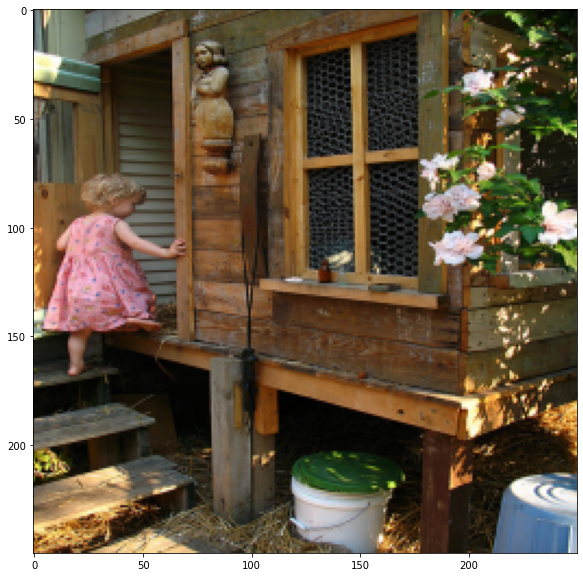

Translated Sentence 1 : one in a wooden playhouse 
Associated Neg Log Probability: [3.8021026] 

Translated Sentence 2 : a girl climbing a wooden playhouse 
Associated Neg Log Probability: [2.9975247] 

Translated Sentence 3 : the in a into a cement stairs building 
Associated Neg Log Probability: [6.8061767] 

Translated Sentence 4 : two climbing in in front of a wooden playhouse 
Associated Neg Log Probability: [4.7179832] 

Translated Sentence 5 : an girl a a pink dress platform in a wooden playhouse 
Associated Neg Log Probability: [7.041553] 



In [54]:
evaluate_with_beam('./Images/1000268201_693b08cb0e.jpg', 5)

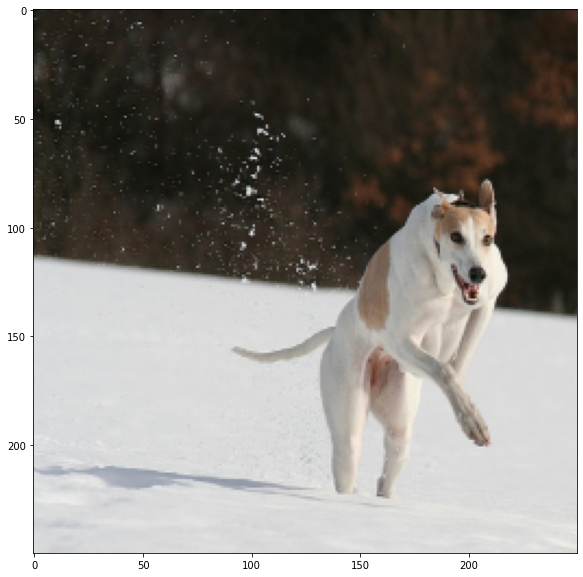

Translated Sentence 1 : the in the snow 
Associated Neg Log Probability: [2.166009] 

Translated Sentence 2 : a running through the snow 
Associated Neg Log Probability: [2.4389138] 

Translated Sentence 3 : an is running through the snow 
Associated Neg Log Probability: [3.46835] 

Translated Sentence 4 : man and brown dog is running through the snow 
Associated Neg Log Probability: [4.2144785] 

Translated Sentence 5 : there dog is running running through on the snow 
Associated Neg Log Probability: [5.741092] 



In [55]:
evaluate_with_beam(images_paths[10], 5)

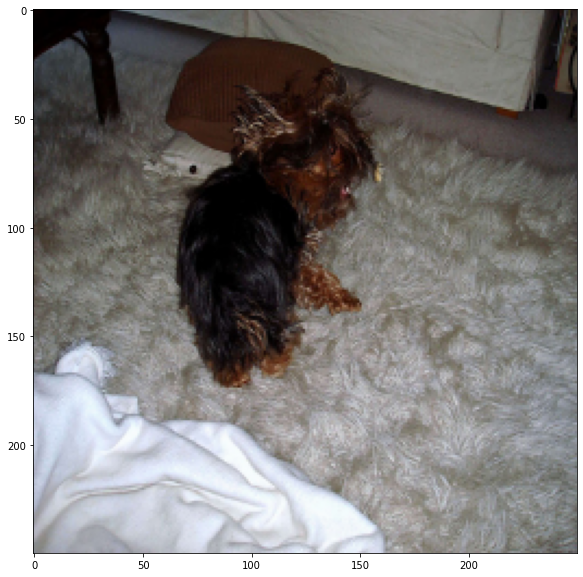

Translated Sentence 1 : a dog with a shaggy rug 
Associated Neg Log Probability: [3.2922149] 

Translated Sentence 2 : the brown is laying white carpet 
Associated Neg Log Probability: [4.0257087] 

Translated Sentence 3 : brown black laying down on a shaggy rug 
Associated Neg Log Probability: [4.9769673] 

Translated Sentence 4 : large dog black dog with a shaggy carpet 
Associated Neg Log Probability: [4.7762194] 

Translated Sentence 5 : dog and and black dog with a shaggy carpet 
Associated Neg Log Probability: [4.807009] 



In [56]:
evaluate_with_beam(images_paths[200], 5)

### Section 6 - Evaluation of the Model

Any model has to be evaluated to know how good it is or to compare it with other models.

Machine translations is textual data and BLEU is a metric that can help to evaluate the translations with the correct translations that should be given. It is based on an n-gram model where it looks at the words appearing in the candidate translation with the reference translation. There are obvious limitations to this evaluation such as it will look at the word's and nearby words' positions only.

NLTK's bleu_score library gives this functionality. It looks at 1-gram to 4-gram and gives an average value (not exactly average) for how good the translations match with each other.

The below example shows a singular comparison using sentence_bleu. The reader can evaluate the model on test set using corplus_bleu. For more information, do refer nltk library and this article - https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

In [57]:
from nltk.translate.bleu_score import sentence_bleu

# Real Caption
reference = ['A girl going into a wooden building'.split()]

# Predicted Caption (for example)
candidate = 'A girl going into a wooden hut'.split()

score = sentence_bleu(reference, candidate)

print(score)

0.8091067115702212


In [58]:
reference, candidate

([['A', 'girl', 'going', 'into', 'a', 'wooden', 'building']],
 ['A', 'girl', 'going', 'into', 'a', 'wooden', 'hut'])

In [59]:
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

Cumulative 1-gram: 0.857143
Cumulative 2-gram: 0.845154
Cumulative 3-gram: 0.831376
Cumulative 4-gram: 0.809107
